<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw7/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 251 (delta 115), reused 224 (delta 93), pack-reused 0
Receiving objects: 100% (251/251), 52.61 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (115/115), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22407 sha256=6f7fe4af025e668f07e763083e68e7bf7a86f54177e008f0b2785ef01128d3bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-f0dbysgk/wheels/55/59/29/0fb1c63565215

In [2]:
from dul_2021.utils.hw7_utils import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


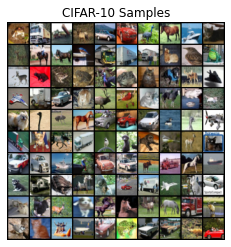

In [5]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [26]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """

## Results

Files already downloaded and verified



..........Inception score: 6.062043


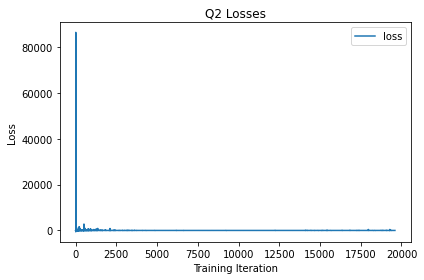

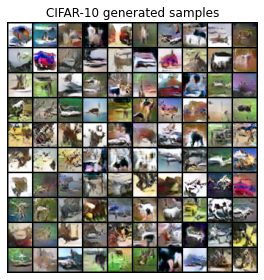

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


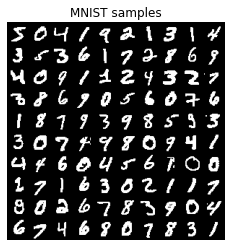

In [28]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """

## Results

In [ ]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

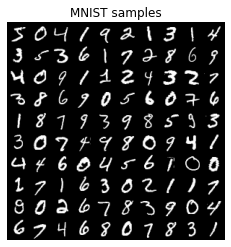

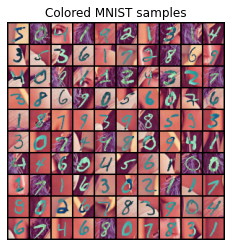

In [29]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

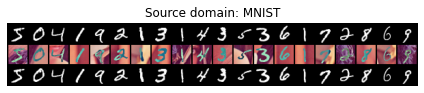

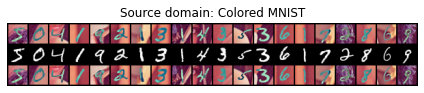

In [ ]:
b5_save_results(b5)